In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from IPython.display import Image
from qutip import *
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from lmfit import Parameters,minimize, fit_report

The single qubit simulation will use system constants from this paper by Majer et al.: https://www.nature.com/articles/nature06184. The Qutip notebook the code is derived from can be found at: https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/rabi-oscillations.ipynb.
\\
This simulation makes use of the Tavis-Cummings Hamiltonian: \\
$$\hat{H}/\hbar = \omega_c\hat{a}^{†}a + \sum_{i=1}^{N} \frac{1}{2}\omega_{qi}\hat{\sigma}_z + \frac{1}{2}g_{i}(\hat{a}\hat{\sigma}^{+}_{i} + \hat{a}^{†}\hat{\sigma}^{-}_{i})$$

### Setting the system constants
All constant in units of GHz, the set values are from Majer. Time is in units of nanoseconds.

In [8]:
wq1 = 5.19  * 2* np.pi # 6.617 * GHz * 2* np.pi # wq = sqrt(8EjEc)
wq2 = 5.19 * 2* np.pi # 2.88 * GHz * 2* np.pi # 6.529 * GHz * 2* np.pi
wc = 5.19 * 2* np.pi # 5.19 * GHz * 2 * np.pi, 3 works
g1 = 0.105 * 2 * np.pi # 0.105 * GHz * 2 * np.pi
g2 = 0.105 * 2 * np.pi # g1
N = 20 # numberof qubit fock states considered
# cavity dissapation rate
kappa = 0.0033 * 2 * np.pi
# qubit dissapation rate
gamma1 = 0.00261 * 2* np.pi
gamma2 = gamma1

use_rwa = False 
n1 = 1 # number photons starting in qubit 1 
n2 = 0 # number photons starting in qubit 2
# times to evolve over
tlist = np.linspace(0, 18, 10000)

#### Time dependent Hamiltonian term
Paper by Yang et al.: https://arxiv.org/pdf/1810.00652.pdf 
Yang et al. finds a time dependent frequency drift in the hybridized energy levels of the qubits-cavity system. As a result the cavity doesn't change frequency while the qubits do, so detuning gets larger. We correct for this by adding a drift factor to the cavity frequency - this is $\frac{g^{2}_{i}}{\Delta(t)}$. 

In [4]:

# create drift factor for cavity frequency
if (wc-wq1) != 0 and (wc-wq2) != 0:
    dwc = g1**2/(wc-wq1)**2 + g2**2/(wc-wq2)**2
else:
    dwc = 0
    
def wc_dep(t,args):
    return wc + dwc

### Operators and Hamiltonian
The destroy() and qeye() matrices are default Fock basis, with the specified size. The model we are assuming has cavity-qubit-qubit for indicies

In [10]:
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
nc = a.dag()*a

# qubit 1 operators
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
nq1 = sm1.dag() * sm1

# qubit 2 operators 
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
nq2 = sm2.dag() * sm2

# Control Hamiltionians for each system
Hc = nc
Hq1 = -0.5 * sz1 * wq1
Hq2 = -0.5 * sz2 * wq2
if use_rwa:
    Hc1 = g1 * (a.dag()*sm1 + a*sm1.dag())
    Hc2 = g2 * (a.dag()*sm2 + a*sm2.dag())
else:
    Hc1 = g1 * (a.dag() + a)*(sm1 + sm1.dag())
    Hc2 = g2 * (a.dag() + a)*(sm2 + sm2.dag())

H = [[Hc, wc_dep], Hq1, Hq2, Hc1, Hc2]

### Calculate the Theoretical Rabi Frequency
We can calculate the Rabi frequency for the Tavis-Cummings model to compare the simulation value to later. The general equation is: $$\Omega_i = \sqrt{4Ng^{2}_{i} + \Delta^{2}_{i}}$$ for the ith qubit of N qubits

In [11]:
if abs(wq1-wc) == abs(wq2-wc): #and (abs(wq1-wc) == abs(wq2-wc)):
    r1 = sqrt(2*4*(g1**2)*(n1 + 1) + (wq1-wc)**2)
    r2 = sqrt(2*4*(g2**2)*(n2 + 1) + (wq2-wc)**2)
else:
    print("Rabi frequency prediction is inaccurate")
    r1 = 0
    r2 = 0
print(f"qubit 1 rabi frequency {r1} GHz, qubit 2 rabi frequency {r2} GHz")

qubit 1 rabi frequency 2.638937829015426 GHz, qubit 2 rabi frequency 1.8660108340265136 GHz


### Time Evolution of the System
First we place quanta in one qubit excited state, with the cavity remaining in ground state. We define the collapse operators to add noise to our system. We specify expectation values we are interested in finding - namely the number of quanta in the qubit and the number of quanta in the cavity.

In [12]:
# create dissapation operators list
collapse_ops = [sqrt(kappa) * a, sqrt(gamma1) * sm1, sqrt(gamma2) * sm2] 
# put qubit in excited state to start 
psi0 = tensor(basis(N,0), basis(2,n1), basis(2,n2))
# make the system evolve 
output = mesolve(H, psi0, tlist, collapse_ops, [nc, nq1, nq2])

### Graphing the Output
Now we can graph the output expectation values according to the system evolution. First we do this without fitting:

Text(0.5, 1.0, 'Vacuum Rabi oscillations')

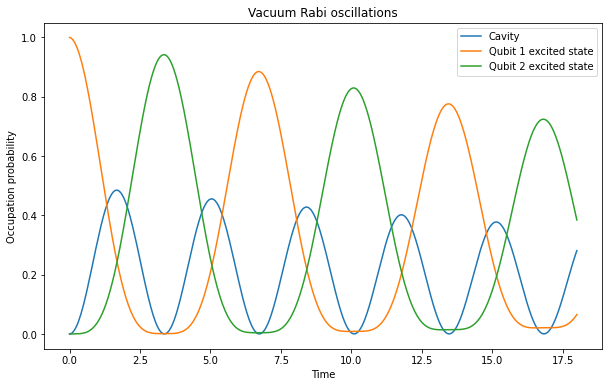

In [13]:
# expectation for number of quanta in cavity over tlist
n_c = output.expect[0]
# same for qubit 1
n_q1 = output.expect[1]
# same for qubit 2
n_q2 = output.expect[2]

# create the figure + plot the results
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_q1, label="Qubit 1 excited state")
axes.plot(tlist, n_q2, label="Qubit 2 excited state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')